In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
from scipy.optimize import minimize
from skimage import data, transform, img_as_float
from skimage.color import rgb2gray
import tifffile
from scipy.optimize import differential_evolution


def load_image_from_csv(path):
    data = np.loadtxt(path, delimiter=',')  # or use np.genfromtxt if NaNs possible
    return data

def apply_transform(image, angle, tx, ty):
    """Rotate around image center, then apply translation."""
    center = np.array(image.shape[::-1]) / 2  # (x, y) order
    tform = (
        transform.SimilarityTransform(translation=-center) +
        transform.SimilarityTransform(rotation=np.deg2rad(angle)) +
        transform.SimilarityTransform(translation=center) +
        transform.SimilarityTransform(translation=(tx, ty))
    )
    return transform.warp(image, tform.inverse, mode='edge')

# Load images
img = apply_transform(load_image_from_csv(f"Wider_Cropped_RCF_Data/Data_20250606/1RCF{stack_energy1}.csv"), -0.34, 0, 0)
img_mov = load_image_from_csv(f"Wider_Cropped_RCF_Data/Data_20250606/1RCF{stack_energy2}.csv")  # change as needed



In [348]:
# def apply_transform(image, angle, tx, ty):
#     """Rotate around center, then translate."""
#     center = np.array(image.shape) / 2
#     # print(f"Center of rotation: {center}")
#     rot = transform.SimilarityTransform(rotation=np.deg2rad(angle))
#     trans = transform.SimilarityTransform(translation=(tx, ty))
#     full_tform = trans + rot + transform.SimilarityTransform(translation=-center) + transform.SimilarityTransform(translation=center)
#     return transform.warp(image, full_tform.inverse, mode='edge')

def apply_transform(image, angle, tx, ty):
    """Rotate around image center, then apply translation."""
    center = np.array(image.shape[::-1]) / 2  # (x, y) order
    tform = (
        transform.SimilarityTransform(translation=-center) +
        transform.SimilarityTransform(rotation=np.deg2rad(angle)) +
        transform.SimilarityTransform(translation=center) +
        transform.SimilarityTransform(translation=(tx, ty))
    )
    return transform.warp(image, tform.inverse, mode='edge')



def ssd_cost(params, ref, mov):
    angle, tx, ty = params
    transformed = apply_transform(mov, angle, tx, ty)
    return np.sum((ref - transformed) ** 2)

def ncc_cost(params, ref, mov):
    angle, tx, ty = params
    transformed = apply_transform(mov, angle, tx, ty)
    ref_zero_mean = ref - np.mean(ref)
    mov_zero_mean = transformed - np.mean(transformed)
    numerator = np.sum(ref_zero_mean * mov_zero_mean)
    denominator = np.sqrt(np.sum(ref_zero_mean ** 2) * np.sum(mov_zero_mean ** 2))
    ncc = numerator / denominator if denominator != 0 else 0
    return 1 - ncc  # minimize 1 - NCC

stack_num1 = 5
stack_energy1 = 11.4
stack_num2 = 6  # Change this to match your stack number
stack_energy2 = 12.7

# Load images
# img = apply_transform(load_image_from_csv(f"Wider_Cropped_RCF_Data/Data_20250606/1RCF{stack_energy1}.csv"), -0.34, 0, 0)
img = load_image_from_csv(f"Wider_Cropped_RCF_Data/Data_20250606/1RCF{stack_energy1}.csv")
img_mov = load_image_from_csv(f"Wider_Cropped_RCF_Data/Data_20250606/1RCF{stack_energy2}.csv")  # change as needed

# Choose cost function: ssd_cost or ncc_cost
cost_function = ncc_cost  # or ssd_cost

# Initial guess: angle=0, tx=0, ty=0
initial_guess = [0.0, 0.0, 0.0]

# Run optimization
result = minimize(cost_function, initial_guess, args=(img, img_mov), method='Powell')

best_angle, best_tx, best_ty = result.x

# Apply best transform
# img = apply_transform(img_mov, best_angle, best_tx, best_ty)
aligned_image = apply_transform(img_mov, best_angle, best_tx, best_ty)


best_angle, best_tx, best_ty
bin_spacing_um = 84.6
bin_spacing_mm = bin_spacing_um / 1000

original_cost = cost_function(initial_guess, img, img_mov)
aligned_cost = cost_function([best_angle, best_tx, best_ty], img, img_mov)
print(f"Initial cost: {original_cost:.2f}")
print(f"Aligned cost: {aligned_cost:.2f}")
print(f"Best angle: {best_angle:.2f} degrees")
print(f"Best translation (x, y): ({best_tx:.2f}, {best_ty:.2f}) pixels")
print(f"Best translation (x, y): ({best_tx*bin_spacing_mm:.2f}, {best_ty*bin_spacing_mm:.2f}) mm")

Initial cost: 0.52
Aligned cost: 0.40
Best angle: 5.50 degrees
Best translation (x, y): (7.48, -3.15) pixels
Best translation (x, y): (0.63, -0.27) mm


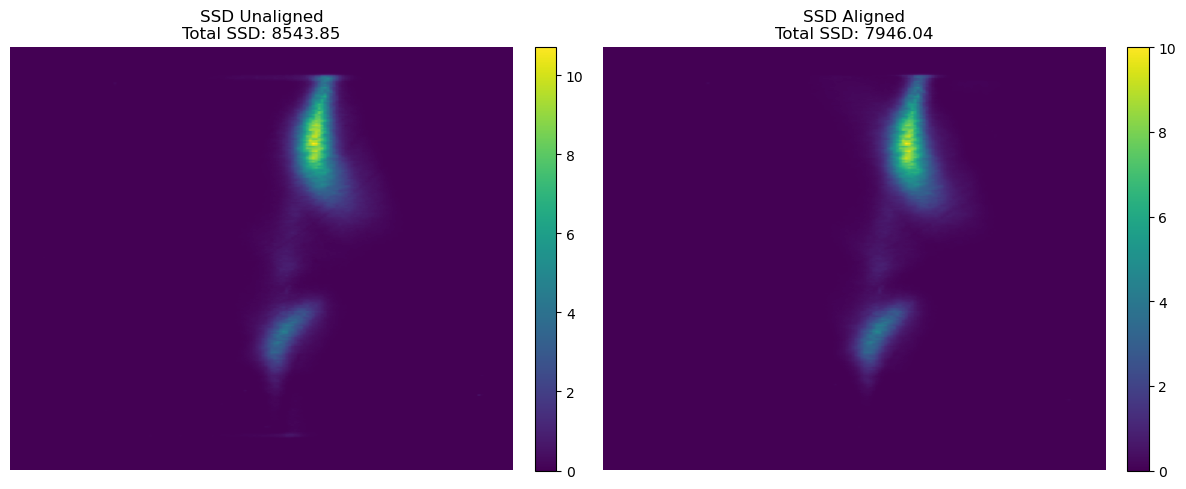

In [349]:
# Compute 2D SSD maps for the entire image
ssd_map_unaligned = (img - img_mov) ** 2
ssd_map_aligned = (img - aligned_image) ** 2

total_ssd_unaligned = np.sum(ssd_map_unaligned)
total_ssd_aligned = np.sum(ssd_map_aligned)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im0 = axs[0].imshow(ssd_map_unaligned, aspect='auto')
axs[0].set_title(f'SSD Unaligned\nTotal SSD: {total_ssd_unaligned:.2f}')
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(ssd_map_aligned, aspect='auto')
axs[1].set_title(f'SSD Aligned\nTotal SSD: {total_ssd_aligned:.2f}')
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f'12MeV_cascading_stack_{stack_num2}_ssd_maps.png', dpi=300, bbox_inches='tight')
plt.show()

(280, 170)
[0, 14.382, 0, 23.688]


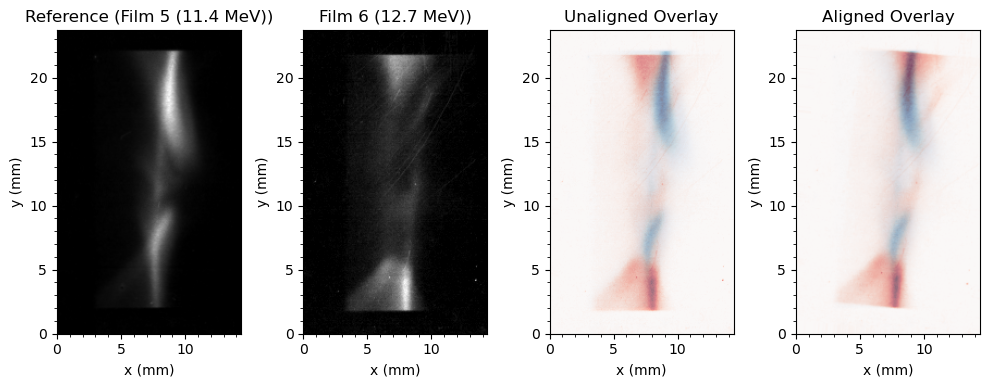

Best angle: 5.50 degrees
Best translation (x, y): (0.63, -0.27) mm
Best translation (x, y): (7.48, -3.15) pixels


In [350]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

aligned_image = apply_transform(img_mov, best_angle, best_tx, best_ty)
bin_spacing_um = 84.6  # in micrometers
bin_spacing_mm = bin_spacing_um / 1000  # convert to mm

ny, nx = img.shape  # assuming all images are the same size

print(img.shape)



# Define physical axis limits: [xmin, xmax, ymin, ymax]
extent = [0, nx * bin_spacing_mm, 0, ny * bin_spacing_mm]
print(extent)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(img, cmap='gray', extent=extent)
axs[0].set_title(f'Reference (Film {stack_num1} ({stack_energy1} MeV))')
axs[1].imshow(img_mov, cmap='gray', extent=extent)
axs[1].set_title(f'Film {stack_num2} ({stack_energy2} MeV))')
axs[2].imshow(img, cmap='Blues', extent=extent)
axs[2].imshow(img_mov, cmap='Reds', alpha=0.5, extent=extent)
axs[2].set_title('Unaligned Overlay')
axs[3].imshow(img, cmap='Blues', extent=extent)
axs[3].imshow(aligned_image, cmap='Reds', alpha=0.5, extent=extent)
axs[3].set_title('Aligned Overlay')

# Add red square (2 cm × 2 cm = 20 mm × 20 mm) to each subplot
square_size = 20  # mm
square = Rectangle((0, 0), square_size, square_size, linewidth=1.5,
                   edgecolor='red', facecolor='none')

for ax in axs:
    # ax.add_patch(Rectangle((0, 1.9), square_size, square_size,
                        #    linewidth=1.5, edgecolor='red', facecolor='none'))
    ax.minorticks_on()
    # ax.set_xlim(-1, 20)
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")

plt.tight_layout()
plt.savefig(f'cascading_stack_{stack_num2}_aligned_films.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best angle: {best_angle:.2f} degrees")
print(f"Best translation (x, y): ({best_tx*bin_spacing_mm:.2f}, {best_ty*bin_spacing_mm:.2f}) mm")
print(f"Best translation (x, y): ({best_tx:.2f}, {best_ty:.2f}) pixels")


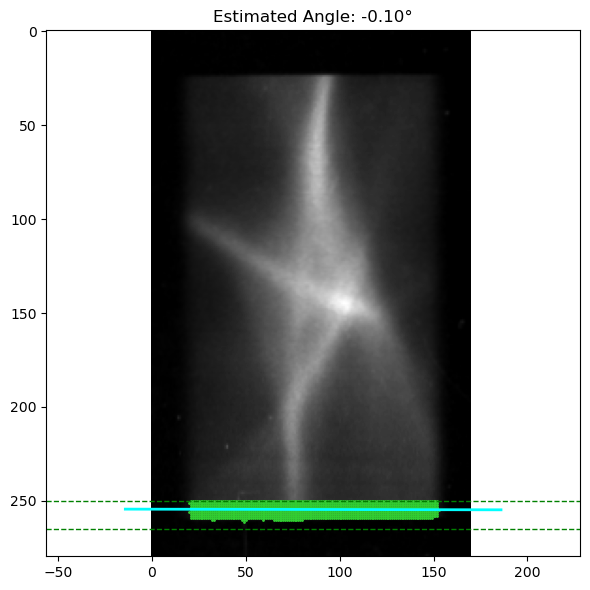

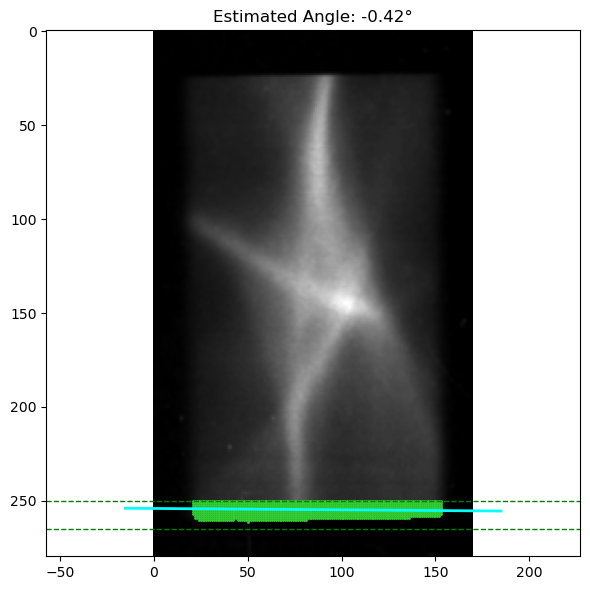

-0.4230742058485504


In [322]:
from sklearn.decomposition import PCA

def estimate_rotation(img, threshold=0.21, plot=True):
    """
    Estimate rotation angle using only the top and bottom crop_fraction of the thresholded region.
    Displays the cropped regions used for PCA.
    """
    binary = img > threshold
    y, x = np.nonzero(binary)

    if len(y) < 10:
        print("Not enough structure for angle estimation.")
        return 0

    coords = np.column_stack((x, y))
    
    xmin = 35
    xmax = 145
    
    ymin = 250
    ymax = 265
    

    # Select top and bottom rows
    top = coords[coords[:, 1] <= 0]
    bottom = coords[(ymin <= coords[:, 1]) & (coords[:, 1] <= ymax)]

    # edge_coords = coords[(xmin <= coords[:, 0]) & (coords[:, 0] <= xmax)]

    edge_coords = np.vstack((top, bottom))

    # Perform PCA on cropped edge coordinates
    pca = PCA(n_components=2)
    pca.fit(edge_coords)

    # Compute angle
    angle_rad = np.arctan2(pca.components_[0, 1], pca.components_[0, 0])
    angle_deg = np.rad2deg(angle_rad)
    angle_deg = ((angle_deg + 90) % 180) - 90

    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray')
        
        # Plot all thresholded points in red (faint)
        plt.scatter(coords[:, 0], coords[:, 1], s=2, c='red', alpha=0., label='All thresholded points')

        # Highlight top and bottom regions used for PCA in green
        plt.scatter(edge_coords[:, 0], edge_coords[:, 1], s=1, alpha=1, c='limegreen', label='Top/Bottom used for PCA')

        # Draw PCA direction vector
        center = pca.mean_
        vector = pca.components_[0] * 100  # scale for visibility
        x_vals = [center[0] + vector[0], center[0] - vector[0]]
        y_vals = [center[1] - vector[1], center[1] + vector[1]]
        plt.plot(x_vals, y_vals, color='aqua', linewidth=2, label='PCA axis')
        plt.xlim(-1, 1)

        # Add visual bounds for the crop
        plt.axhline(ymin, color='green', linestyle='--', linewidth=1)
        plt.axhline(ymax, color='green', linestyle='--', linewidth=1)

        plt.title(f"Estimated Angle: {angle_deg:.2f}°")
        plt.axis('equal')
        # plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    return angle_deg



stack_num1 = 3
stack_energy1 = 8.2

# Load images
img = load_image_from_csv(f"Wider_Cropped_RCF_Data/Data_20250606/1RCF{stack_energy1}.csv")
angle = estimate_rotation(img)
aligned_image = apply_transform(img, -0.341 ,0,0)
angle_2 = estimate_rotation(aligned_image)

print(angle_2)


['Wider_Cropped_RCF_Data/Data_20250606/1RCF3.1.csv', 'Wider_Cropped_RCF_Data/Data_20250606/1RCF6.1.csv', 'Wider_Cropped_RCF_Data/Data_20250606/1RCF8.2.csv', 'Wider_Cropped_RCF_Data/Data_20250606/1RCF9.9.csv', 'Wider_Cropped_RCF_Data/Data_20250606/1RCF11.4.csv', 'Wider_Cropped_RCF_Data/Data_20250606/1RCF12.7.csv', 'Wider_Cropped_RCF_Data/Data_20250606/1RCF13.9.csv', 'Wider_Cropped_RCF_Data/Data_20250606/1RCF15.0.csv']


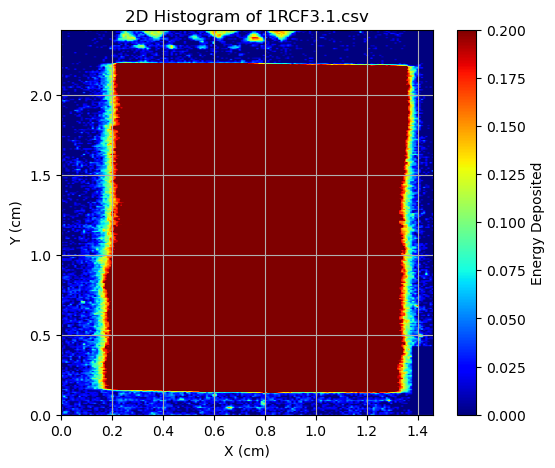

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF3.1.csv: 20953.998778765297


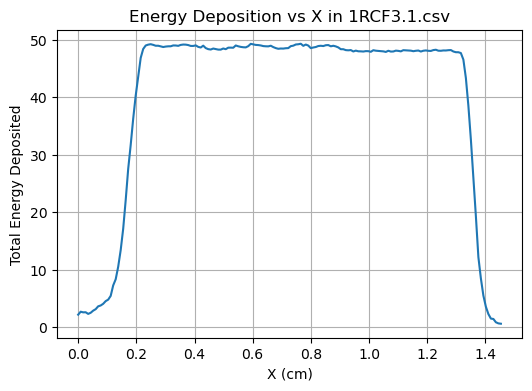

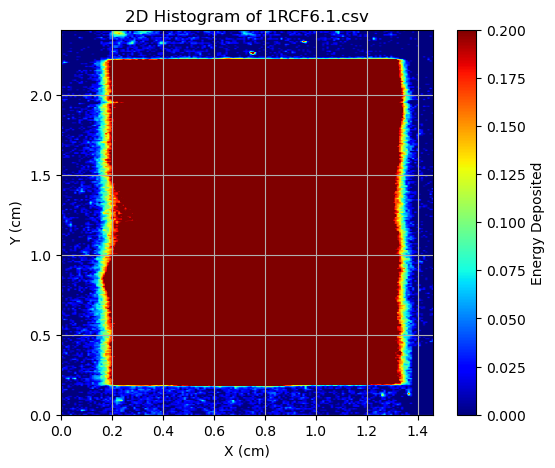

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF6.1.csv: 20204.69247332506


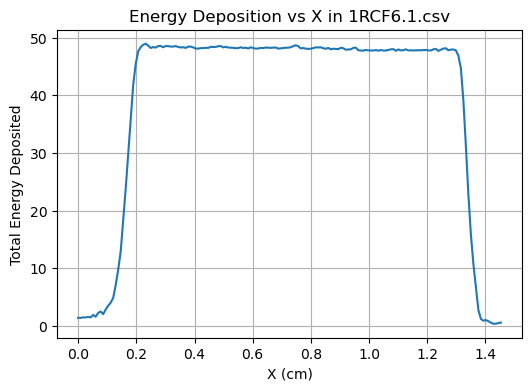

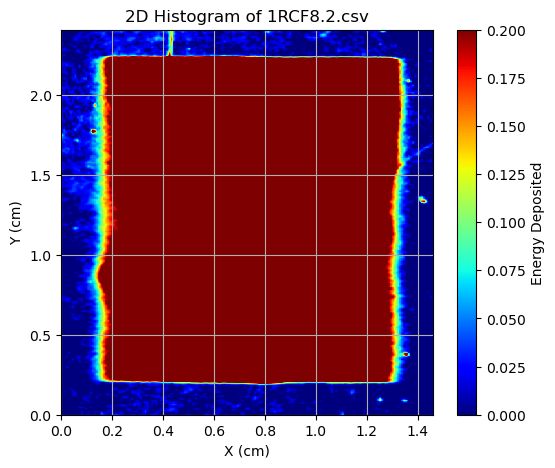

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF8.2.csv: 22171.043423227347


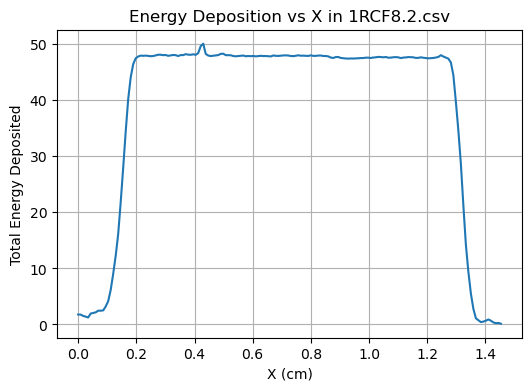

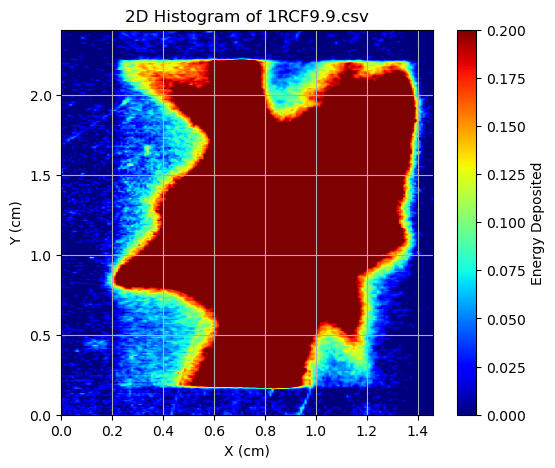

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF9.9.csv: 20220.032748575984


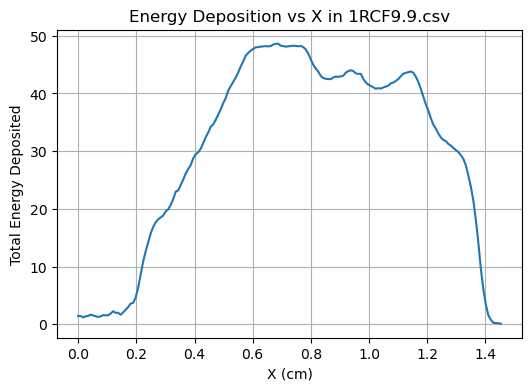

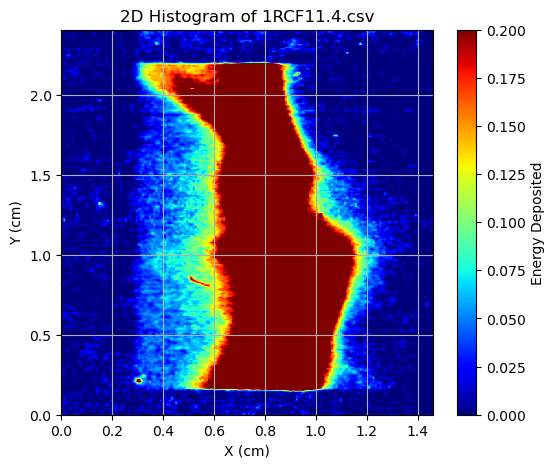

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF11.4.csv: 9752.420638592645


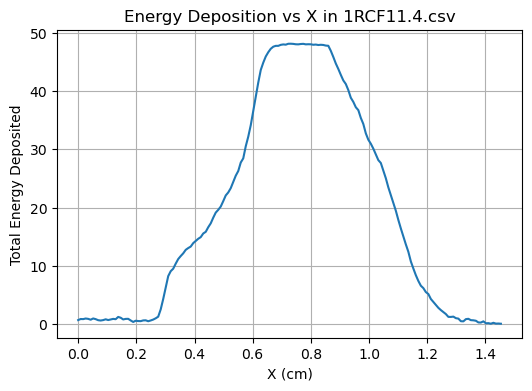

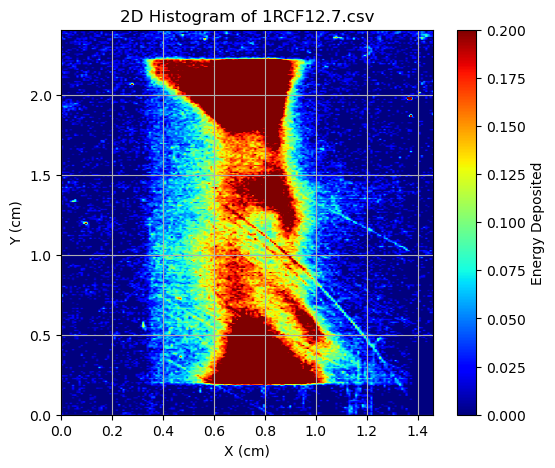

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF12.7.csv: 3346.016271022175


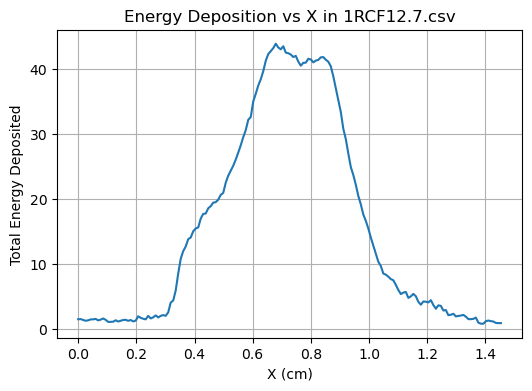

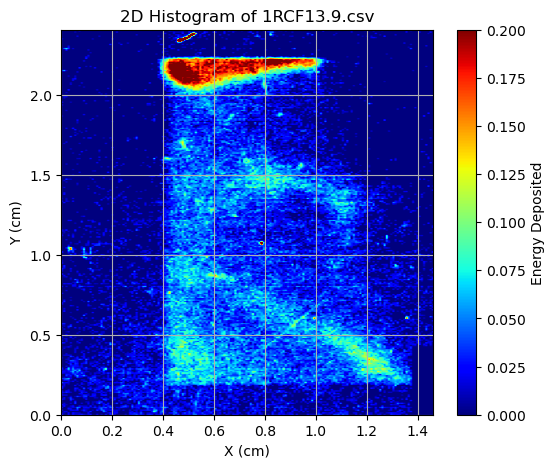

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF13.9.csv: 1124.4769748419012


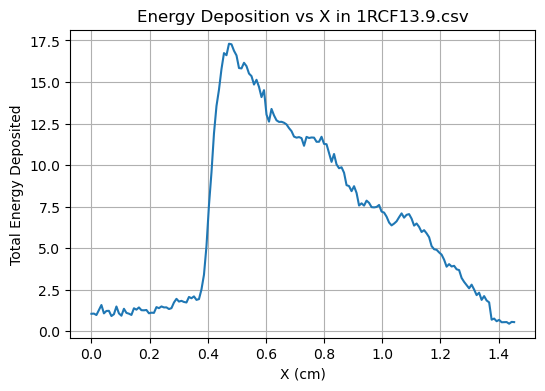

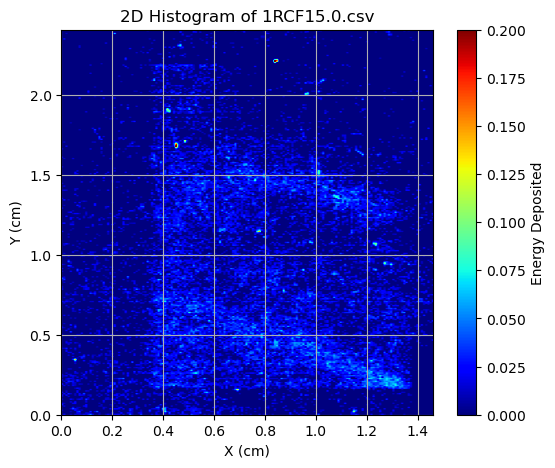

Total energy deposited in Wider_Cropped_RCF_Data/Data_20250606/1RCF15.0.csv: 366.44766747391935


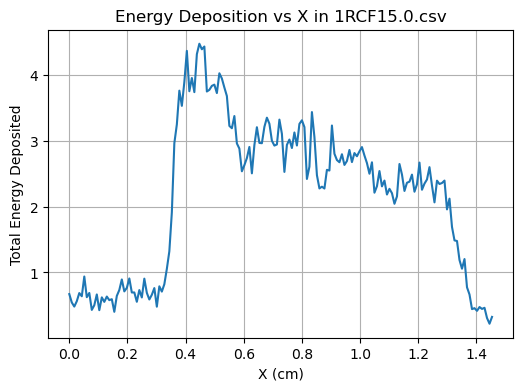

In [323]:
import numpy as np
import pandas as pd
import glob
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt
import re

# Find all CSV files in the current directory
csv_files = glob.glob("Wider_Cropped_RCF_Data/Data_20250606/1RCF*.csv")

# Parameters
spacing_cm = 0.0086 #Pixel Spacing provided by Nick
# csv_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
csv_files = sorted(csv_files, key=lambda f: float(re.search(r'1RCF([0-9.]+)\.csv', f).group(1)))

print(csv_files)
vmax=0.2

for file in csv_files:
    # Load the CSV file
    data = pd.read_csv(file, header=None)
    values = data.values

    # Create x and y coordinates based on spacing
    nrows, ncols = values.shape
    x = np.arange(ncols) * spacing_cm
    y = np.arange(nrows) * spacing_cm
    # Plot 2D histogram (heatmap) weighted by energy deposited
    plt.figure(figsize=(6, 5))
    plt.imshow(values, extent=[x[0], x[-1]+spacing_cm, y[0], y[-1]+spacing_cm],
               origin='lower', aspect='auto', cmap='jet', vmin=0, vmax=vmax)
    plt.colorbar(label='Energy Deposited', )
    plt.title(f'2D Histogram of {file.split("/")[-1]}')
    plt.xlabel('X (cm)')
    plt.ylabel('Y (cm)')
    # plt.xlim(-0.5, 0.5)
    # plt.ylim(-0.5, 0.5)
    plt.grid(True)
    plt.show()

    # Sum all values
    total_energy = np.sum(values)
    print(f"Total energy deposited in {file}: {total_energy}")

    clipped_values = np.clip(values, 0, vmax)
    energy_vs_x = clipped_values.sum(axis=0)

    plt.figure(figsize=(6, 4))
    plt.plot(x, energy_vs_x)
    plt.title(f'Energy Deposition vs X in {file.split("/")[-1]}')
    plt.xlabel('X (cm)')
    plt.ylabel('Total Energy Deposited')
    plt.grid(True)
    plt.show()

/var/folders/d0/vlfx4xyd1yn_ltyvnt9tzf_00000gn/T/ipykernel_24087/2392864287.py:3: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[0, 0].imshow(img[:, 650:900], cmap='gray')
/var/folders/d0/vlfx4xyd1yn_ltyvnt9tzf_00000gn/T/ipykernel_24087/2392864287.py:4: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[0, 0].imshow(img_mov[:, 650:900], cmap='jet', alpha=0.2)
/var/folders/d0/vlfx4xyd1yn_ltyvnt9tzf_00000gn/T/ipykernel_24087/2392864287.py:6: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[0, 1].imshow(img[:, 1050:1250], cmap='gray')
/var/folders/d0/vlfx4xyd1yn_ltyvnt9tzf_00000gn/T/ipykernel_24087/2392864287.py:7: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[0, 

NameError: name 'stack_num' is not defined

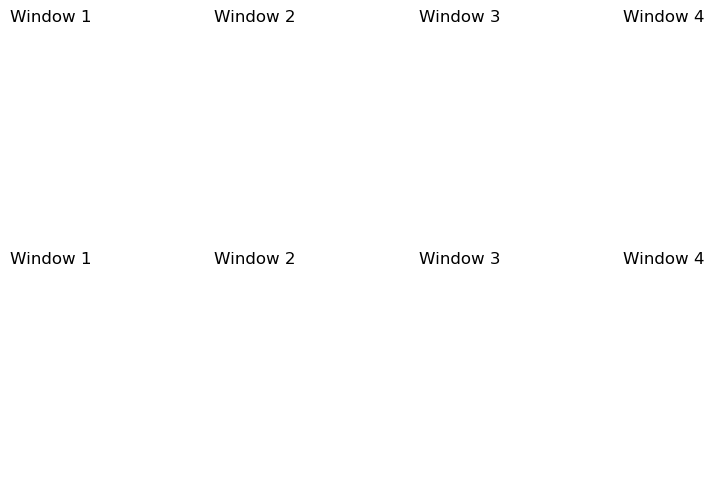

In [27]:
# Plotting
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
axs[0, 0].imshow(img[:, 650:900], cmap='gray')
axs[0, 0].imshow(img_mov[:, 650:900], cmap='jet', alpha=0.2)
axs[0, 0].set_title('Window 1')
axs[0, 1].imshow(img[:, 1050:1250], cmap='gray')
axs[0, 1].imshow(img_mov[:, 1050:1250], cmap='jet', alpha=0.2)
axs[0, 1].set_title('Window 2')
axs[0, 2].imshow(img[:, 1400:1600], cmap='gray')
axs[0, 2].imshow(img_mov[:, 1400:1600], cmap='jet', alpha=0.2)
axs[0, 2].set_title('Window 3')
axs[0, 3].imshow(img[:, 1750:2000], cmap='gray')
axs[0, 3].imshow(img_mov[:, 1750:2000], cmap='jet', alpha=0.2)
axs[0, 3].set_title('Window 4')
axs[1, 0].imshow(img[:, 650:900], cmap='gray')
axs[1, 0].imshow(aligned_image[:, 650:900], cmap='jet', alpha=0.2)
axs[1, 0].set_title('Window 1')
axs[1, 1].imshow(img[:, 1050:1250], cmap='gray')
axs[1, 1].imshow(aligned_image[:, 1050:1250], cmap='jet', alpha=0.2)
axs[1, 1].set_title('Window 2')
axs[1, 2].imshow(img[:, 1400:1600], cmap='gray')
axs[1, 2].imshow(aligned_image[:, 1400:1600], cmap='jet', alpha=0.2)
axs[1, 2].set_title('Window 3')
axs[1, 3].imshow(img[:, 1750:2000], cmap='gray')
axs[1, 3].imshow(aligned_image[:, 1750:2000], cmap='jet', alpha=0.2)
axs[1, 3].set_title('Window 4')
for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.savefig(f'stack_{stack_num}_aligned_films_windows.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/d0/vlfx4xyd1yn_ltyvnt9tzf_00000gn/T/ipykernel_70939/2752040584.py:10: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  im0 = axs[0, j].imshow(ssd_unaligned, aspect='auto')
/var/folders/d0/vlfx4xyd1yn_ltyvnt9tzf_00000gn/T/ipykernel_70939/2752040584.py:17: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  im1 = axs[1, j].imshow(ssd_aligned, aspect='auto')


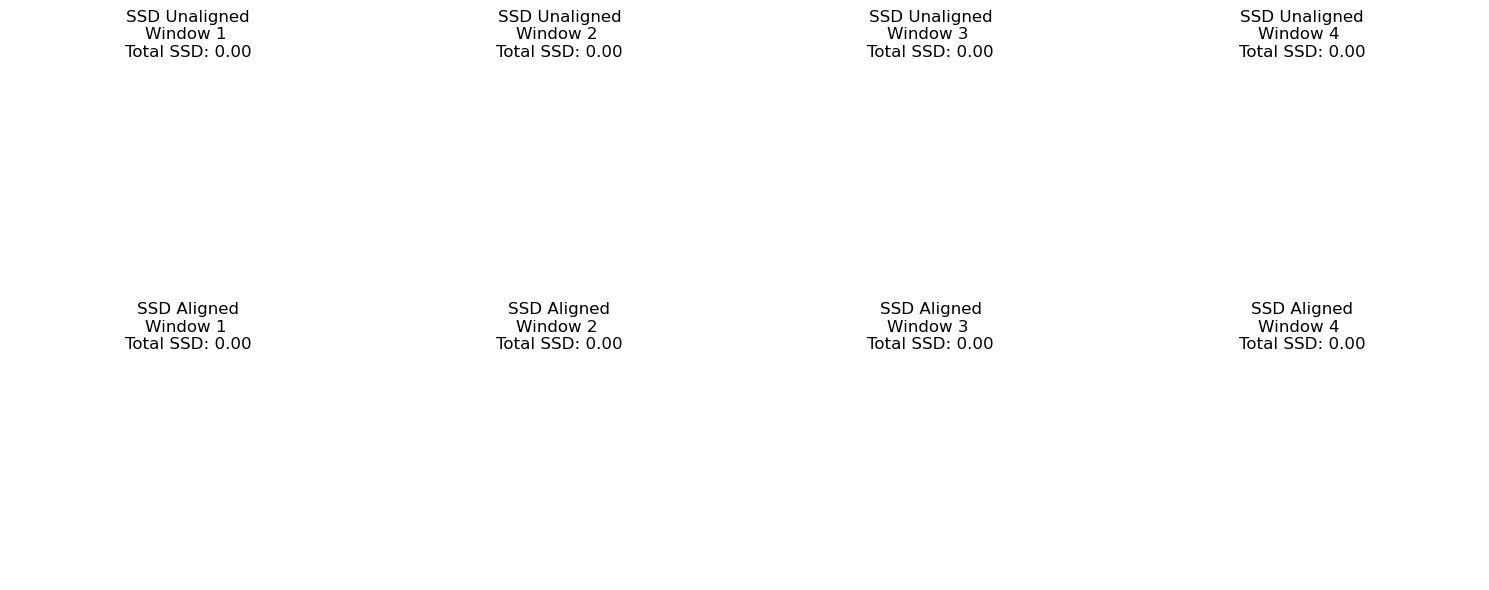

In [8]:
# Compute 2D SSD map between aligned_image and img in the same region
ssd_map = (img - aligned_image) ** 2

fig, axs = plt.subplots(2, 4, figsize=(15, 6))
windows = [(650, 900), (1050, 1250), (1400, 1600), (1750, 2000)]
for j, (start, end) in enumerate(windows):
    # Top row: SSD heatmap for unaligned
    ssd_unaligned = (img[:, start:end] - img_mov[:, start:end]) ** 2
    total_ssd_unaligned = np.sum(ssd_unaligned)
    im0 = axs[0, j].imshow(ssd_unaligned, aspect='auto')
    axs[0, j].set_title(f'SSD Unaligned\nWindow {j+1} \nTotal SSD: {total_ssd_unaligned:.2f}')
    axs[0, j].axis('off')

    # Bottom row: SSD heatmap for aligned
    ssd_aligned = (img[:, start:end] - aligned_image[:, start:end]) ** 2
    total_ssd_aligned = np.sum(ssd_aligned)
    im1 = axs[1, j].imshow(ssd_aligned, aspect='auto')
    axs[1, j].set_title(f'SSD Aligned\nWindow {j+1} \nTotal SSD: {total_ssd_aligned:.2f}')
    axs[1, j].axis('off')

plt.tight_layout()
# plt.savefig(f'stack_{stack_num}_aligned_films_ssd_windows.png', dpi=300, bbox_inches='tight')
plt.show()
